In [1]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
%matplotlib inline
import mdtraj
plt.rc('font', family='serif')

from msmbuilder.example_datasets import FsPeptide
dataset = FsPeptide().get()
fs_trajectories = dataset.trajectories
fs_t = fs_trajectories[0]

loading trajectory_1.xtc...
loading trajectory_10.xtc...
loading trajectory_11.xtc...
loading trajectory_12.xtc...
loading trajectory_13.xtc...
loading trajectory_14.xtc...
loading trajectory_15.xtc...
loading trajectory_16.xtc...
loading trajectory_17.xtc...
loading trajectory_18.xtc...
loading trajectory_19.xtc...
loading trajectory_2.xtc...
loading trajectory_20.xtc...
loading trajectory_21.xtc...
loading trajectory_22.xtc...
loading trajectory_23.xtc...
loading trajectory_24.xtc...
loading trajectory_25.xtc...
loading trajectory_26.xtc...
loading trajectory_27.xtc...
loading trajectory_28.xtc...
loading trajectory_3.xtc...
loading trajectory_4.xtc...
loading trajectory_5.xtc...
loading trajectory_6.xtc...
loading trajectory_7.xtc...
loading trajectory_8.xtc...
loading trajectory_9.xtc...


In [486]:
print(dataset.DESCR)

This dataset consists of 28 molecular dynamics trajectories of Fs peptide
(Ace-A_5(AAARA)_3A-NME), a widely studied model system for protein folding.
Each trajectory is 500 ns in length, and saved at a 50 ps time interval (14
us aggegrate sampling). The simulations were performed using the AMBER99SB-ILDN
force field with GBSA-OBC implicit solvent at 300K, starting from randomly
sampled conformations from an initial 400K unfolding simulation. The
simulations were performed with OpenMM 6.0.1.

The dataset, including the script used to generate the dataset
is available on figshare at

http://dx.doi.org/10.6084/m9.figshare.1030363



In [489]:
from simtk.unit import *
(50 * picosecond * 1000) / nanosecond

49.99999999999999

In [2]:
# idea: define basis functions as centered on conformations, represented in some vector space

In [9]:
from msmbuilder.featurizer import DihedralFeaturizer
dih_model=DihedralFeaturizer()
X = dih_model.fit_transform(fs_trajectories)

In [11]:
from msmbuilder.decomposition import tICA
tica = tICA(lag_time=100,weighted_transform=True)

In [12]:
X = tica.fit_transform(X)

In [14]:
X_ = np.vstack(X)

In [15]:
from sklearn.mixture import GMM

In [191]:
gmm=GMM(20)

In [192]:
gmm.fit(X_[::10])

GMM(covariance_type='diag', init_params='wmc', min_covar=0.001,
  n_components=20, n_init=1, n_iter=100, params='wmc', random_state=None,
  thresh=0.01)

In [193]:
gmm.predict_proba(X_[:10]).shape

(10, 20)

In [194]:
basis_exp = gmm.predict_proba(X_)

In [150]:
gmm.means_.shape

(10, 84)

In [133]:
from scipy.stats import norm

np.sum(norm.logpdf(gmm.means_[0],loc=gmm.means_[0],scale=gmm.covars_[0]))

-638.05269500156032

In [134]:
def compute_basis_exp(points,gmm):
    basis_exp = np.zeros((len(points),len(gmm.means_)))
    for i in range(len(points)):
        for j in range(len(gmm.means_)):
            basis_exp[i,j] = np.sum(norm.logpdf(points[i],loc=gmm.means_[j],scale=gmm.covars_[j]))
    return basis_exp

In [135]:
basis_exp = compute_basis_exp(X_,gmm)

In [136]:
def compute_S(basis_exp):
    return basis_exp.T.dot(basis_exp) / len(basis_exp)

def compute_C(basis_exp,tau=10):
    return basis_exp[tau:].T.dot(basis_exp[:-tau]) / len(basis_exp - tau)

In [195]:
S = compute_S(basis_exp)
C = compute_C(basis_exp,tau=1000)

In [196]:
dtrajs = [gmm.predict(x) for x in X]

In [197]:
from msmbuilder.msm import MarkovStateModel
msm = MarkovStateModel(lag_time=100)
msm.fit(dtrajs)

MSM contains 1 strongly connected component above weight=0.01. Component 0 selected, with population 100.000000%


MarkovStateModel(ergodic_cutoff=0.01, lag_time=100, n_timescales=10,
         prior_counts=0, reversible_type='mle', sliding_window=True,
         verbose=True)

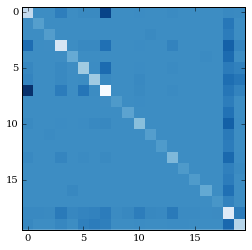

In [198]:
plt.imshow(msm.transmat_-np.diag(np.ones(len(msm.transmat_))),interpolation='none',cmap='Blues')

In [214]:
n_states = basis_exp.shape[1]
#A = np.diag(np.ones(n_states))
#A = np.random.randn(n_states,n_states)
#A = msm.transmat_

In [215]:
msm.countsmat_.shape

(20, 20)

In [216]:
P = A.T.dot(C).dot(A)
P.shape

(20, 20)

In [217]:
Q = A.T.dot(S).dot(A)

In [218]:
Q_inv = np.linalg.inv(Q)

In [219]:
gmrq = np.trace(P.dot(Q_inv))
gmrq

13.258986439108194

In [220]:
gmrq_no_rates = gmrq
gmrq_no_rates

13.258986439108194

In [221]:
gmrq-gmrq_no_rates

0.0

In [222]:
msm.score_

10.661001699764459

In [225]:
references = [x[::1000] for x in fs_trajectories]

In [229]:
refs = references[0]
for ref in references[1:]:
    refs = refs + ref

In [326]:
basis_exps = []
for traj in fs_trajectories:
    rmsd_to_refs = np.zeros((len(traj),len(refs)))
    for i in range(len(refs)):
        rmsd_to_refs[:,i] = mdtraj.rmsd(traj,refs,i)
    basis_exps.append(rmsd_to_refs)

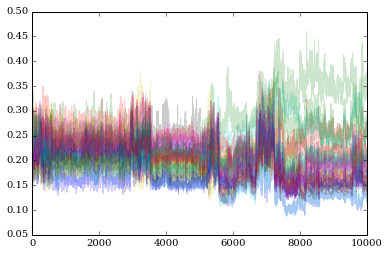

In [271]:
plt.plot(np.exp(-rmsd_to_refs/0.5)[:,20:][:,::10],alpha=0.2);

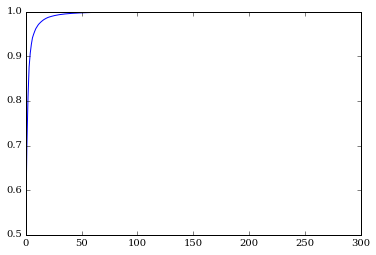

In [272]:
X = np.exp(-rmsd_to_refs/0.5)
#X = np.random.randn(10000,280)
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(X)
plt.plot(np.cumsum(pca.explained_variance_ratio_))

In [274]:
from scipy import linalg as la

In [404]:
Cs = []
Ss = []

C_avg = np.zeros((len(X.T),len(X.T)))
S_avg = np.zeros((len(X.T),len(X.T)))

for traj in basis_exps:
    X = np.exp(-traj/0.5)
    C = compute_C(X,tau=100)
    S = compute_S(X)
    Cs.append(C)
    Ss.append(S)
    C_avg += C
    S_avg += S
C_avg /= len(basis_exps)
S_avg /= len(basis_exps)
    

soln = la.eig(C_avg,S_avg)

In [701]:
from MDAnalysis.analysis.rms import rmsd as wRMSD
ref0 = refs.xyz[-1]
weights = np.ones(264)

def compute_rmsd_traj(trajectory,ref,weights):
    traj = np.zeros(len(trajectory))
    for i in range(len(trajectory)):
        traj[i] = wRMSD(ref,trajectory.xyz[i],weights=weights,center='True')
    return traj

In [702]:
raw_traj = compute_rmsd_traj(fs_t,ref0,weights)

In [716]:
#weights=np.zeros(264)
atomwise_deviations = np.load('fs_atomwise_deviations_tau=20.npy')
mean = atomwise_deviations.mean(0)
#weights = 1 - mean
weights = np.exp(-mean/0.065)

weighted_traj = compute_rmsd_traj(fs_t,ref0,weights)
inv_mean_weighted_traj = compute_rmsd_traj(fs_t,ref0,1/mean)
mean_weighted_traj = compute_rmsd_traj(fs_t,ref0,mean)

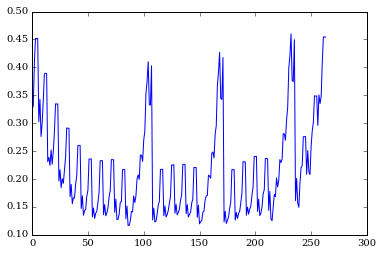

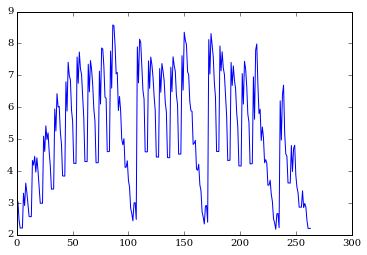

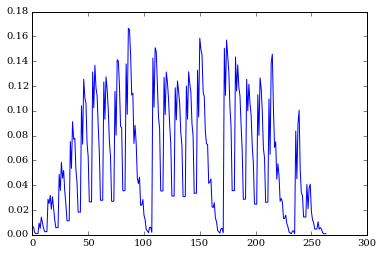

In [717]:
plt.plot(mean)
plt.figure()
plt.plot(1/mean)
plt.figure()
plt.plot(weights)

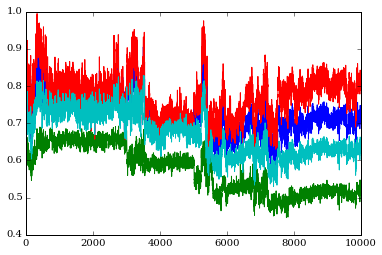

In [718]:
plt.plot(raw_traj)
plt.plot(weighted_traj)
plt.plot(mean_weighted_traj)
plt.plot(inv_mean_weighted_traj)

(3.2413283950363998, 339.50192896282294, 1100.4372425168287, 98.283894227759319, 814.38016850341069)


(0, 1)

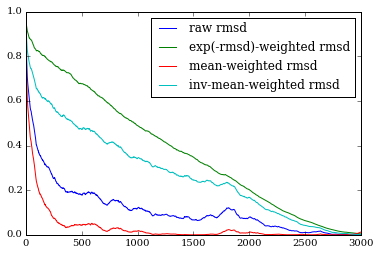

In [726]:
from statsmodels.tsa.stattools import acf

nlags=3000
autocorr = acf(raw_traj,nlags=nlags)**2
autocorr_w = acf(weighted_traj,nlags=nlags)**2
autocorr_mw = acf(mean_weighted_traj,nlags=nlags)**2
autocorr_imw = acf(inv_mean_weighted_traj,nlags=nlags)**2


plt.plot(autocorr,label='raw rmsd')
print(np.sum(autocorr_w)/np.sum(autocorr),np.sum(autocorr),np.sum(autocorr_w),np.sum(autocorr_mw),np.sum(autocorr_imw))
plt.plot(autocorr_w,label='exp(-rmsd)-weighted rmsd')
plt.plot(autocorr_mw,label='mean-weighted rmsd')
plt.plot(autocorr_imw,label='inv-mean-weighted rmsd')

plt.legend(loc='best')
plt.ylim(0,1)

In [687]:
deviations = []
for i in range(len(fs_trajectories)):
    deviations.append(atomwise_deviations[i*10000:(i+1)*10000])

In [694]:
autocorr = np.array([acf(dev.dot(weights),nlags=9000)**2 for dev in deviations]).T

(9001, 28)

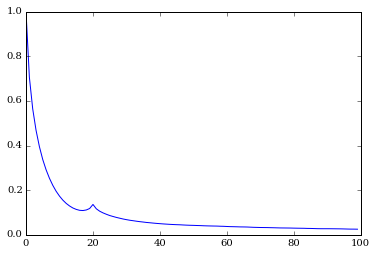

In [699]:
plt.plot(autocorr.mean(1)[:100]);

In [407]:
# discarding imaginary components
eigs = np.array(soln[0],dtype=float)

/Users/joshuafass/anaconda/envs/py27/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: ComplexWarning: Casting complex values to real discards the imaginary part
  from IPython.kernel.zmq import kernelapp as app


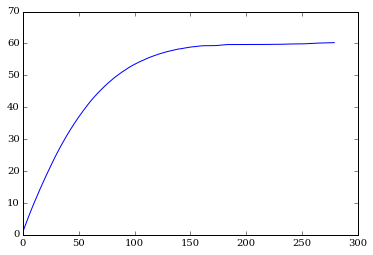

In [408]:
plt.plot(np.cumsum(eigs**2))

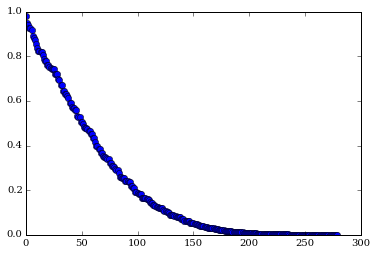

In [409]:
plt.plot(sorted(eigs**2)[::-1],marker='o')

In [410]:
np.sum(sorted(eigs)[::-1][:20])

18.528596046519947

In [494]:
dtrajs_rmsd = [np.argmax(traj,1) for traj in basis_exps]

dtrajs_gauss_rmsd = [np.argmax(np.exp(-traj),1) for traj in basis_exps]

In [412]:
from pyemma import msm
m = msm.estimate_markov_model(dtrajs,lag=100)

In [413]:
m.fit(dtrajs)

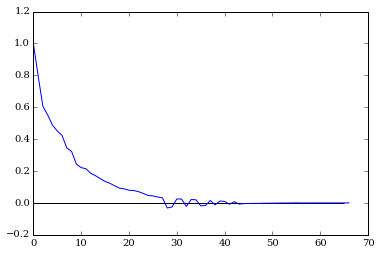

In [414]:
plt.plot(m.eigenvalues())
plt.hlines(0,0,65)

In [420]:
sum(sorted(m.eigenvalues())[::-1][:20])

6.7202184002614409

18.091430057815153

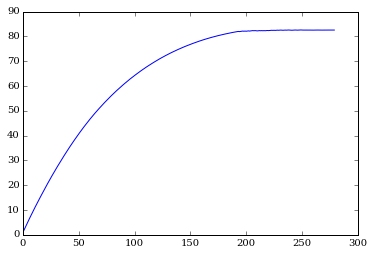

In [472]:
import pyemma
tica = pyemma.coordinates.tica(basis_exps,lag=100)
plt.plot(np.cumsum(tica.eigenvalues))
np.sum(tica.eigenvalues[:20])

17.847446125059605

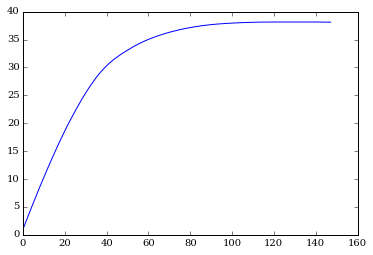

In [476]:
from msmbuilder.featurizer import DihedralFeaturizer
dih_model = DihedralFeaturizer(types=['phi', 'psi', 'omega', 'chi1', 'chi2', 'chi3', 'chi4'])
X = dih_model.fit_transform(fs_trajectories)
from msmbuilder.decomposition import tICA
tica = tICA(lag_time=100)
tica.fit(X)
plt.plot(np.cumsum(tica.eigenvalues_))
np.sum(tica.eigenvalues_[:20])

In [499]:
from msmbuilder.cluster import MiniBatchKMedoids
kmed = MiniBatchKMedoids(20)
dtrajs = kmed.fit_transform(X)

In [500]:
m = pyemma.msm.estimate_markov_model(dtrajs,lag=100)
np.sum(m.eigenvalues())

6.9022995755793444

In [501]:
kmed = MiniBatchKMedoids(20)
tica = tICA(n_components=50,lag_time=100,weighted_transform=True)
dtrajs_tica = kmed.fit_transform(tica.fit_transform(X))

In [507]:
set(dtrajs[1]),set(dtrajs_tica[1])

({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 13, 18}, {0, 1, 5, 8, 14})

In [513]:
lags = range(1,50) + range(50,1000)[::50]

In [514]:
# kmed_raw
kmed_raw = pyemma.msm.its(dtrajs,lags,nits=1,errors='bayes')

# kmed_tica
kmed_tica = pyemma.msm.its(dtrajs_tica,lags,nits=1,errors='bayes')

# rmsd
rmsd = pyemma.msm.its(dtrajs_rmsd,lags,nits=1,errors='bayes')

# gauss_rmsd
gauss_rmsd = pyemma.msm.its(dtrajs_gauss_rmsd,lags,nits=1,errors='bayes')

/Users/joshuafass/anaconda/envs/py27/lib/python2.7/site-packages/msmtools-1.1-py2.7-macosx-10.5-x86_64.egg/msmtools/estimation/dense/transition_matrix.py:192: NotConvergedWarning: Reversible transition matrix estimation didn't converge.
  warnings.warn("Reversible transition matrix estimation didn't converge.", msmtools.util.exceptions.NotConvergedWarning)


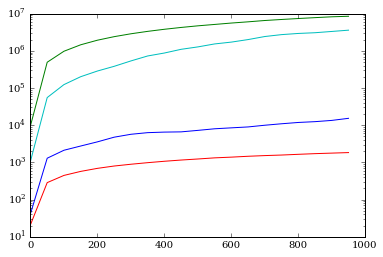

In [508]:
its = kmed_raw
plt.plot(its.lags,its.get_timescales(),label='Kmed, raw dihedrals')
#plt.fill_between(its.lags,its.get_timescales() + its.


its = kmed_tica
plt.plot(kmed_tica.lags,its.get_timescales(),label='Kmed, tICA-transformed dihedrals')


its = rmsd
plt.plot(its.lags,its.get_timescales(),label='RMSD to references')


its = gauss_rmsd
plt.plot(its.lags,its.get_timescales(),label='np.exp(-RMSD) to references')

plt.yscale('log')
plt.legend(loc='best')

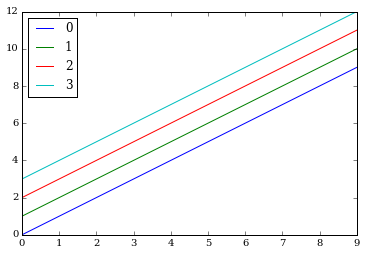

In [512]:
for i in range(4):
    plt.plot(np.arange(10)+i,label=str(i))
plt.legend(loc='best')

In [490]:
nanosecond / (50* picosecond)

20.000000000000004

In [462]:
#C_msm = m.transition_matrix


one_hot_trajs = []
n_states = np.max(np.vstack(dtrajs))+1
C_msm_avg = np.zeros((n_states,n_states))
S_msm_avg = np.zeros((n_states,n_states))

C_msms = []
S_msms = []
for traj in dtrajs:
    one_hot_traj = np.zeros((len(traj),n_states))
    for i in range(len(traj)):
        one_hot_traj[i,traj[i]] = 1
    one_hot_trajs.append(one_hot_traj)
    C_msm = compute_C(one_hot_traj,tau=100)
    S_msm = compute_S(one_hot_traj)
    
    C_msms.append(C_msm)
    C_msm_avg += C_msm
    
    S_msms.append(S_msm)
    S_msm_avg += S_msm

#C_msm_avg /= len(dtrajs)
#S_msm_avg /= len(dtrajs)

#S_msm = np.diag(m.stationary_distribution)

/Users/joshuafass/anaconda/envs/py27/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':
/Users/joshuafass/anaconda/envs/py27/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()


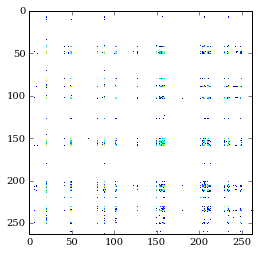

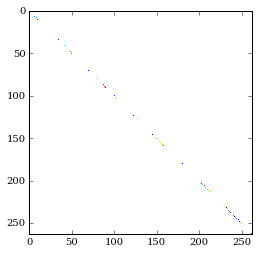

In [465]:
plt.imshow(np.log(C_msm_avg),interpolation='none')
plt.figure()
plt.imshow(np.log(S_msm_avg),interpolation='none')

In [460]:
C_msm_avg.shape,S_msm_avg.shape

((263, 263), (263, 263))

In [454]:
msm_soln = la.eig(C_msm_avg,S_msm_avg)

/Users/joshuafass/anaconda/envs/py27/lib/python2.7/site-packages/scipy/linalg/decomp.py:61: RuntimeWarning: divide by zero encountered in true_divide
  w = (alphar + _I * alphai) / beta
/Users/joshuafass/anaconda/envs/py27/lib/python2.7/site-packages/scipy/linalg/decomp.py:61: RuntimeWarning: invalid value encountered in true_divide
  w = (alphar + _I * alphai) / beta


In [455]:
msm_eigs = sorted(np.array(msm_soln[0],dtype=float))[::-1]
msm_eigs[:20]

/Users/joshuafass/anaconda/envs/py27/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  if __name__ == '__main__':


[nan,
 inf,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 0.0,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan]

In [447]:
sum(msm_eigs[:20])

7108.7867451603724

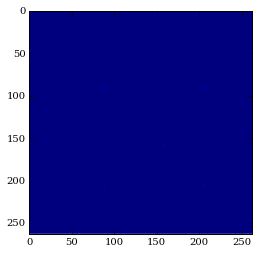

In [448]:
plt.imshow(C_msm,interpolation='none')

In [449]:
msm_soln[0].shape

(67,)